# Phase 2 — Advanced Preprocessing & Feature Engineering

Split before scaling, create Standard and MinMax scaled datasets, correlation analysis, and save processed data for reproducibility.

Train shape: (2262300, 78) Test shape: (565576, 78)
Saved processed data to ..\data\processed\ml_ready


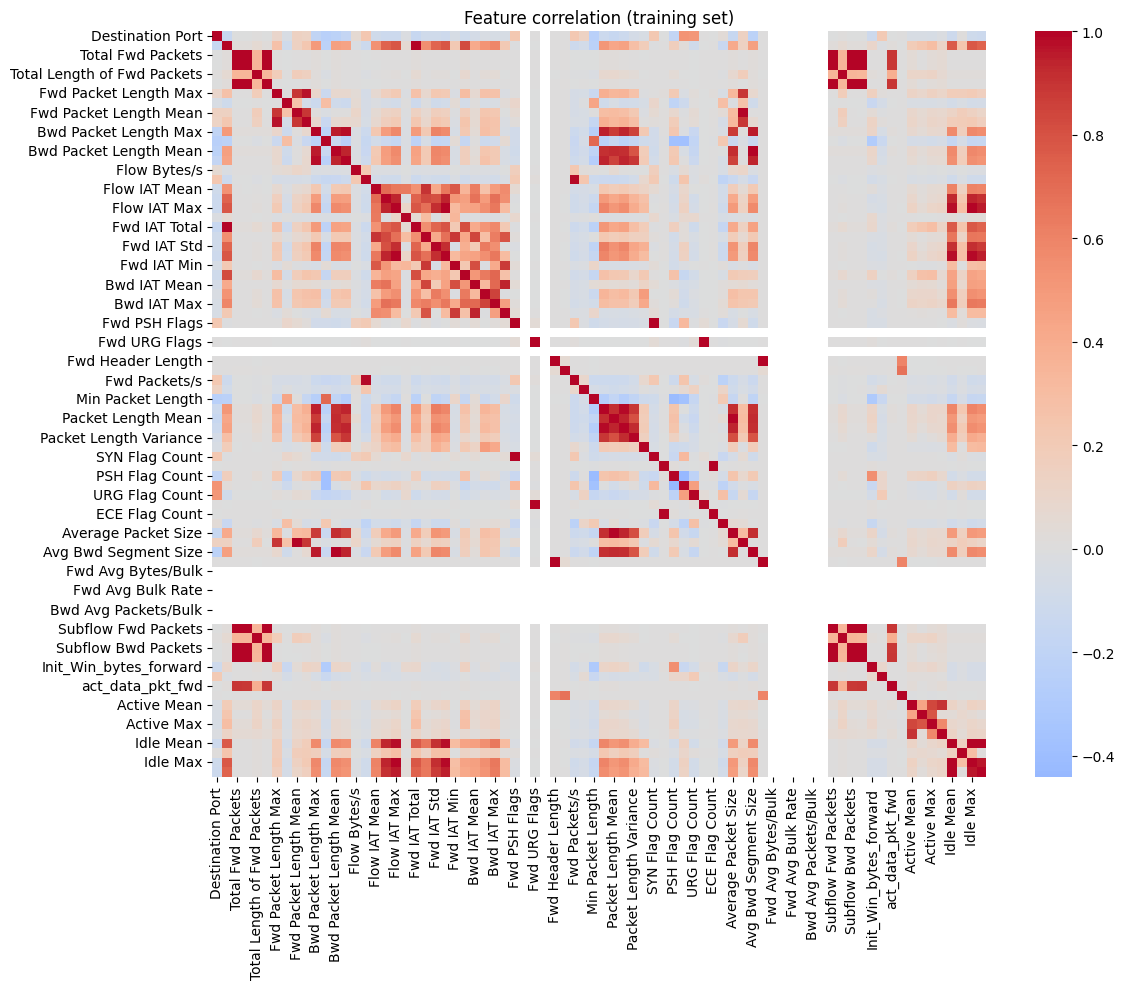

High correlation pairs (>|0.95|): [('Total Backward Packets', 'Total Fwd Packets', np.float64(0.999118172027068)), ('Total Length of Bwd Packets', 'Total Fwd Packets', np.float64(0.9968165877353311)), ('Total Length of Bwd Packets', 'Total Backward Packets', np.float64(0.9943553008049414)), ('Fwd Packet Length Std', 'Fwd Packet Length Max', np.float64(0.968493297838188)), ('Bwd Packet Length Mean', 'Bwd Packet Length Max', np.float64(0.9590766768958536)), ('Bwd Packet Length Std', 'Bwd Packet Length Max', np.float64(0.9827633212239528)), ('Fwd IAT Total', 'Flow Duration', np.float64(0.9985515287605548)), ('Fwd IAT Max', 'Flow IAT Max', np.float64(0.9980765928915547)), ('Fwd Packets/s', 'Flow Packets/s', np.float64(0.9878462828602126)), ('Packet Length Std', 'Max Packet Length', np.float64(0.9844077478759687)), ('SYN Flag Count', 'Fwd PSH Flags', np.float64(1.0)), ('CWE Flag Count', 'Fwd URG Flags', np.float64(1.0)), ('ECE Flag Count', 'RST Flag Count', np.float64(0.9972732999125172)), 

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

DATA_DIR = Path("../data/processed/CICIDS2017")
OUT_DIR = Path("../data/processed/ml_ready")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load consolidated data created in Phase 1
df = pd.read_csv(DATA_DIR / "combined.csv")
X = df.drop(columns=['Label','Label_ID'])
y = df['Label_ID']

# Train-test split BEFORE scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Fit scalers on training data only
std_scaler = StandardScaler().fit(X_train)
mm_scaler = MinMaxScaler().fit(X_train)

X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

X_train_mm = mm_scaler.transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

# Save scalers and processed arrays
joblib.dump(std_scaler, Path("../trained_models/scaler_standard.pkl"))
joblib.dump(mm_scaler, Path("../trained_models/scaler_minmax.pkl"))

pd.DataFrame(X_train_std, columns=X_train.columns).to_csv(OUT_DIR / "X_train_standard.csv", index=False)
pd.DataFrame(X_test_std, columns=X_test.columns).to_csv(OUT_DIR / "X_test_standard.csv", index=False)
pd.DataFrame(X_train_mm, columns=X_train.columns).to_csv(OUT_DIR / "X_train_minmax.csv", index=False)
pd.DataFrame(X_test_mm, columns=X_test.columns).to_csv(OUT_DIR / "X_test_minmax.csv", index=False)

y_train.to_csv(OUT_DIR / "y_train.csv", index=False)
y_test.to_csv(OUT_DIR / "y_test.csv", index=False)

print("Saved processed data to", OUT_DIR)

# Correlation analysis on training set (original features)
corr = X_train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature correlation (training set)")
plt.tight_layout()
plt.show()

# Optionally compute feature pairs with high correlation
threshold = 0.95
high_corr = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i):
        if abs(corr.iloc[i,j]) > threshold:
            high_corr.append((cols[i], cols[j], corr.iloc[i,j]))
print('High correlation pairs (>|0.95|):', high_corr)
